# Cas Kaggle: Estadístiques Lebron James & Michael Jordan

## Matheus Mingorance Maciel, 1562738

### Introducció a la base de dades:

La base de dades utilitzada en aquest estudi està formada per dos conjunts de dades independents que recullen les estadístiques de tots els partits de temporada regular disputats per Michael Jordan i LeBron James al llarg de les seves respectives carreres. Cada registre representa un partit jugat, i inclou un conjunt homogeni d’estadístiques que permet analitzar de manera fiable el perfil dels dos jugadors. Tots dos datasets presenten el mateix nombre de columnes, corresponents a diverses mètriques oficials de la NBA, com punts, rebots, assistències, minuts jugats, percentatges d'encert en el tir, triples i tirs lliures, entre altres estadístiques avançades fent així un total de 26 atributs. Tot i així, cal destacar que la columna minus_plus, inclosa en tots dos fitxers, es troba completament buida en el cas de Jordan. Aquest fet s’explica perquè durant els seus primers anys a la lliga, aquesta estadística encara no es registrava de manera oficial, motiu pel qual aquesta columna només té validesa per a l’etapa moderna del bàsquet i la ignorarem en aquest estudi.

Els datasets contenen exclusivament partits de temporada regular, és a dir, no inclouen cap partit de playoffs. Durant la temporada regular de la NBA es poden disputar fins a un màxim de 82 partits, de manera que cada entrada correspon a un dels partits jugats en aquesta fase. Pel que fa al volum de dades, el conjunt corresponent a Michael Jordan inclou 1072 partits, que representen la totalitat de la seva trajectòria a la competició. En canvi, el dataset de LeBron James conté 1132 partits (aproximadament un 5% més, valor que ens indica un conjunt de dades bastant igualat), però correspon únicament als seus partits fins a la temporada 2017–2018, moment en què LeBron tenia 33 anys. Això significa que el dataset no cobreix la seva activitat esportiva posterior, tot i que LeBron ha continuat jugant fins al present.

Un aspecte rellevant de la base de dades és la presència de valors buits (NaNs) en dues columnes concretes: threep (percentatge d’encert en triples) i ftp (percentatge d’encert en tirs lliures). En ambdós casos, el valor queda buit quan el jugador no ha intentat cap llançament del tipus corresponent en aquell partit. Per exemple, si un jugador acaba un partit amb 0 triples anotats i 0 intents, no es pot calcular un percentatge, de manera que el dataset registra aquesta casella com a valor buit. El mateix passa amb tirs lliures: si un jugador no en realitza cap intent, el seu percentatge de tir lliure no és definible i s’omple amb un valor nul. Aquest comportament és coherent amb les convencions estadístiques de la NBA i requereix un tractament que més tard realitzarem.

En conjunt, els dos datasets proporcionen una base sòlida per dur a terme comparacions, models predictius i anàlisis exploratòries d’aquests dos jugadors icònics.

In [25]:
import pandas as pd

# Carregar datasets
jordan = pd.read_csv("jordan_career.csv", sep=";")
lebron = pd.read_csv("lebron_career.csv", sep=";")

print("=== Primeres files del dataset de Michael Jordan ===")
display(jordan.head())

print("\n=== Primeres files del dataset de LeBron James ===")
display(lebron.head())


=== Primeres files del dataset de Michael Jordan ===


,game,date,age,team,opp,result,mp,fg,fga,fgp,three,threeatt,threep,ft,fta,ftp,orb,drb,trb,ast,stl,blk,tov,pts,game_score,minus_plus
0,1,26/10/1984,21-252,CHI,WSB,W (+16),40:00:00,5,16,0.313,0,0,NaN,6,7,0.857,1,5,6,7,2,4,5,16,12.5,NaN
1,2,27/10/1984,21-253,CHI,MIL,L (-2),34:00:00,8,13,0.615,0,0,NaN,5,5,1.000,3,2,5,5,2,1,3,21,19.4,NaN
2,3,29/10/1984,21-255,CHI,MIL,W (+6),34:00:00,13,24,0.542,0,0,NaN,11,13,0.846,2,2,4,5,6,2,3,37,32.9,NaN
3,4,30/10/1984,21-256,CHI,KCK,W (+5),36:00:00,8,21,0.381,0,0,NaN,9,9,1.000,2,2,4,5,3,1,6,25,14.7,NaN
4,5,01/11/1984,21-258,CHI,DEN,L (-16),33:00:00,7,15,0.467,0,0,NaN,3,4,0.750,3,2,5,5,1,1,2,17,13.2,NaN



=== Primeres files del dataset de LeBron James ===


,game,date,age,team,opp,result,mp,fg,fga,fgp,three,threeatt,threep,ft,fta,ftp,orb,drb,trb,ast,stl,blk,tov,pts,game_score,minus_plus
0,1,29/10/2003,18-303,CLE,SAC,L (-14),42:00:00,12,20,0.600,0,2,0.0,1,3,0.333,2,4,6,9,4,0,2,25,24.7,-9
1,2,30/10/2003,18-304,CLE,PHO,L (-9),41:00:00,8,17,0.471,1,5,0.2,4,7,0.571,2,10,12,8,1,0,7,21,14.7,-3
2,3,01/11/2003,18-306,CLE,POR,L (-19),39:00:00,3,12,0.250,0,1,0.0,2,2,1.000,0,4,4,6,2,0,2,8,5.0,-21
3,4,05/11/2003,18-310,CLE,DEN,L (-4),41:00:00,3,11,0.273,0,2,0.0,1,1,1.000,2,9,11,7,2,3,2,7,11.2,-3
4,5,07/11/2003,18-312,CLE,IND,L (-1),44:00:00,8,18,0.444,1,2,0.5,6,7,0.857,0,5,5,3,0,0,7,23,9.0,-7


### Anàlisi dels atributs i models que vull entrenar:

Un cop preparats i analitzats els datasets originals de Michael Jordan i LeBron James, vaig dur a terme una exploració detallada dels atributs disponibles per tal d’identificar quines tasques d’aprenentatge automàtic podien aportar valor al projecte. Aquesta fase d’anàlisi preliminar es va basar tant en una inspecció estadística dels atributs com en una exploració de correlacions per determinar fins a quin punt certes variables podien predir comportaments o ajudar a discriminar entre els dos jugadors.

En primer lloc, vaig examinar l’evolució de les estadístiques ofensives principals, especialment les relacionades amb la puntuació, que es lo més important. L’anàlisi visual i numèrica de LeBron James, combinat amb la disponibilitat de totes les estadístiques de LeBron fins la temporada 2017–2018, em va permetre plantejar un model de regressió específic per a ell, amb l’objectiu de predir quants punts per partit hauria de fer en edats posteriors. La motivació principal d’aquest model era intentar extrapolar l’evolució natural del seu rendiment basant-me únicament en les dades disponibles fins als 33 anys, i posteriorment comparar aquestes prediccions amb estadístiques reals que he recollit manualment de temporades més recents. D’aquesta manera, puc quantificar el grau d’encert de diferents models de regressió i valorar quin d’ells representa millor la progressió real del jugador.

D’altra banda, també vaig estudiar les correlacions entre totes les estadístiques de joc presents als datasets combinats. Aquesta anàlisi va revelar patrons clars en la manera com Jordan i LeBron distribueixen el seu impacte estadístic: LeBron tendeix a obtenir valors més alts en assistències, participació en el joc i eficiència global, mentre que Jordan mostra un perfil més orientat a l’anotació pura i a un volum alt de tirs, però sense molts triples que en aquella època eren més escassos. Observant aquestes diferències estructurals, així com la consistència amb què apareixen en els registres, vaig decidir entrenar un segon model, en aquest cas un model de classificació, amb l’objectiu de determinar, només a partir de les estadístiques d’un partit concret (mp, fg, fga, three, rebots, assistències, etc.), si aquell partit correspon a LeBron o a Jordan.

Aquest model de classificació es basa exclusivament en estadístiques numèriques, sense fer ús d’informació contextual com la data, l’equip o l’oponent, ja que aquests trets farien trivial la classificació. Per validar-lo de manera apropriada, he buscat estadístiques reals de partits de playoffs de tots dos jugadors, que no formen part dels datasets originals (centrats només en temporada regular), creant així un conjunt de dades de test independent. Aquest procés permet avaluar si el model és capaç de generalitzar i identificar correctament de quin jugador és un partit.

En conjunt, aquest procés d’anàlisi d’atributs i correlacions ha guiat la selecció d’aquests dos models: un de regressió i un de classificació, que responen a preguntes d’interès sobre l’evolució estadística i la diferenciació estilística entre dos dels jugadors més importants de la història de la NBA. Així també he pogut tocar dos models que hem tractat a la assignatura, no només un, i he pogut fer que el meu anàlisi sigui més complet.

## Primer Model: Regressió per predir els PPGs de Lebron James en funció de la seva edat

En primer lloc, representem gràficament els punts per partit (PPG) de LeBron James segons l’edat utilitzant únicament les dades disponibles al dataset original, que cobreixen la seva carrera fins als 33 anys. Per això, identifiquem l'edat de cada partit dins del dataset (que venen donades com a 21-134 per exemple, que vol dir 21 anys i 134 dies) i fem la mitja dels seus punts (pts) per cada partit amb aquella edat. Aquest gràfic ens permet visualitzar l’evolució real del seu rendiment ofensiu. A continuació, entrenem tres models de regressió (lineal, polinòmic de grau 2 i polinòmic de grau 3) basats en aquestes dades per tal de generar prediccions del seu PPG més enllà dels 33 anys i analitzar quin model és capaç de descriure millor la seva progressió estadística.

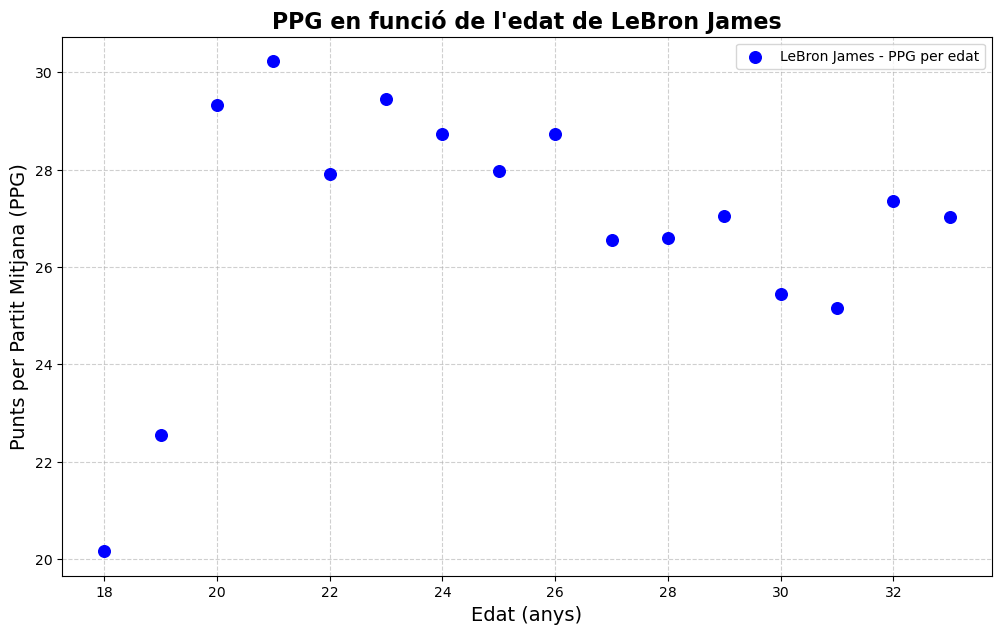

In [26]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

# Carregar datasets 
try:
    lebron = pd.read_csv("lebron_career.csv", sep=";")
except FileNotFoundError:
    print("Error: No es poden carregar els arxius CSV.")
    raise

# Funció per extreure l'edat
def extract_age(age_str):
    if pd.isna(age_str) or not isinstance(age_str, str) or '-' not in age_str:
        return None
    try:
        return int(age_str.split("-")[0])
    except ValueError:
        return None

# Preprocessat per LeBron
for df in [lebron]:
    df["age_years"] = df["age"].apply(extract_age)
    df["pts"] = pd.to_numeric(df["pts"], errors="coerce")
    df.dropna(subset=["age_years", "pts"], inplace=True)

# PPG mitjà per edat
lebron_avg = lebron.groupby("age_years")["pts"].mean().reset_index()

# Gràfic
plt.figure(figsize=(12, 7))

# Punts Lebron
plt.scatter(lebron_avg["age_years"], lebron_avg["pts"],
            color='blue', label='LeBron James - PPG per edat', s=70, zorder=5)

# Títols i estil
plt.title('PPG en funció de l\'edat de LeBron James', fontsize=16, fontweight='bold')
plt.xlabel('Edat (anys)', fontsize=14)
plt.ylabel('Punts per Partit Mitjana (PPG)', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.show()


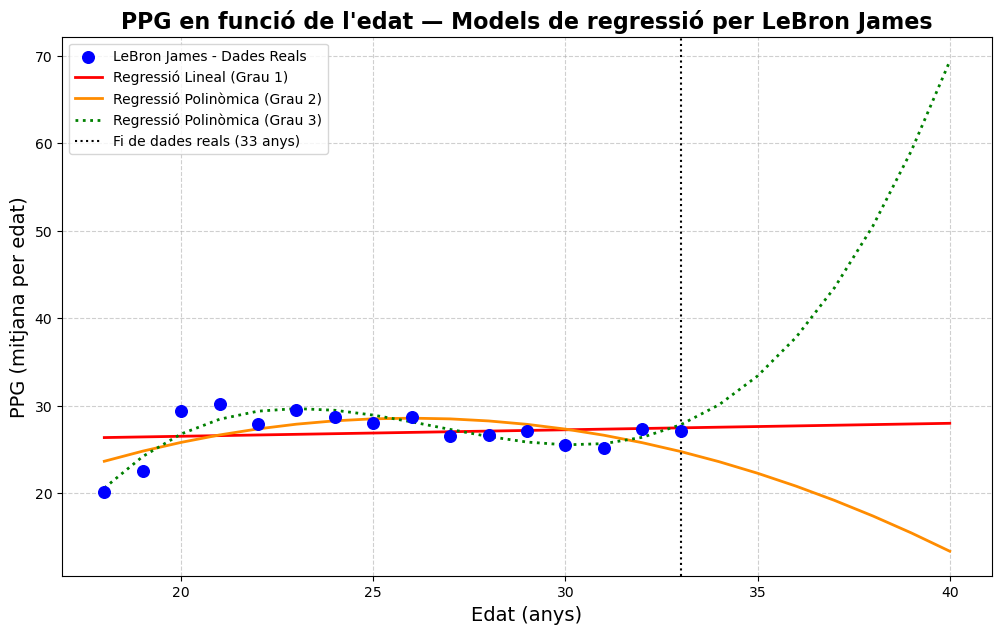

In [27]:
# Preparació dades per regressió
X_train = lebron_avg["age_years"].values.reshape(-1, 1)
Y_train = lebron_avg["pts"].values

# Predir des de min(edat) fins a 40 anys
X_predict = np.arange(X_train.min(), 41).reshape(-1, 1)

# Entrenament models
# Model grau 1
model_linear = LinearRegression()
model_linear.fit(X_train, Y_train)

# Model grau 2
model_poly_2 = make_pipeline(PolynomialFeatures(degree=2), LinearRegression())
model_poly_2.fit(X_train, Y_train)

# Model grau 3
model_poly_3 = make_pipeline(PolynomialFeatures(degree=3), LinearRegression())
model_poly_3.fit(X_train, Y_train)

plt.figure(figsize=(12, 7))

# Punts Lebron
plt.scatter(lebron_avg["age_years"], lebron_avg["pts"],
            color='blue', label='LeBron James - Dades Reals', s=70, zorder=5)

# Corbes de regressió
# Regressió Grau 1 (lineal)
plt.plot(X_predict, model_linear.predict(X_predict),
         linestyle='-', color='red', linewidth=2,
         label='Regressió Lineal (Grau 1)')

# Regressió Grau 2 (polinòmica)
plt.plot(X_predict, model_poly_2.predict(X_predict),
         linestyle='-', color='darkorange', linewidth=2,
         label='Regressió Polinòmica (Grau 2)')

# Regressió Grau 3 (cúbica)
plt.plot(X_predict, model_poly_3.predict(X_predict),
         linestyle=':', color='green', linewidth=2,
         label='Regressió Polinòmica (Grau 3)')

# Línia de tall entre dades reals i extrapolació
plt.axvline(x=X_train.max(), color='black', linestyle=':', linewidth=1.5,
            label=f'Fi de dades reals ({int(X_train.max())} anys)')

# Gràfic
plt.title('PPG en funció de l\'edat — Models de regressió per LeBron James', fontsize=16, fontweight='bold')
plt.xlabel('Edat (anys)', fontsize=14)
plt.ylabel('PPG (mitjana per edat)', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.show()


### Interpretació del gràfic

En el gràfic, veiem clarament que els 3 models donen resultats molt diferents. El model lineal prediu que Lebron James, tot i el pas dels anys, mantindrà el seu poder ofensiu constant, i de fet el millorarà una miqueta. El model de grau 2 prediu un comportament més comú per un jugador normal, on a partir dels 30 comença a haver-hi un empitjorament gradual dels seus punts. Finalment, el model de grau 3 prediu que començarà a pujar exponencialment i amb 40 anys tindrà 70 PPG, cosa que és impossible. Es veu a simple vista que podem descartar el model de grau 3, ja que pateix un clar overfitting i no fa prediccions viables, així que de cara a mirar els resultats després, ja sabem que la competició estarà entre el model lineal i el model de grau 2. A continuació, he buscat les estadístiques reals dels seus PPG per edat a partir dels 33 anys (fins els 39 anys, el seu últim any complet ja que ara mateix té 40). Les he obtingut de https://www.statmuse.com/, i després han estat corroborades en altres pàgines. Un cop obtingudes aquestes dades, he creat un petit dataset molt senzill (lebron_career_post33.csv) on he ficat les dades aconseguides, per poder inclourelas al graf i posteriorment fer la comparació amb les prediccions dels models entrenats, i finalment decidir quin model ha funcionat millor:

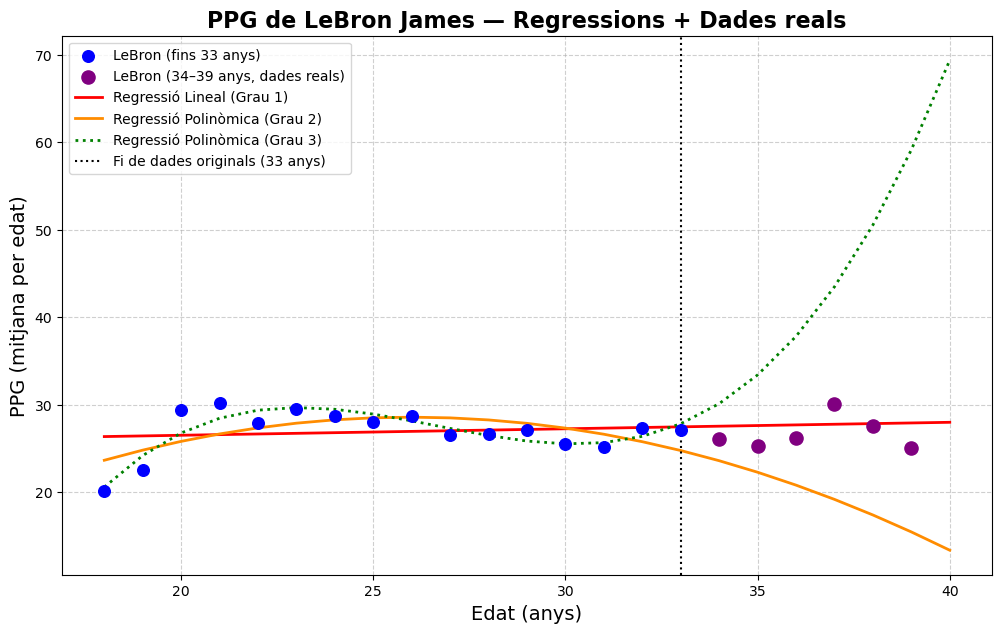

In [29]:
# Carregar dades de LeBron després dels 33 anys
lebron_post = pd.read_csv("lebron_career_post33.csv", sep=';')

# Eliminem columnes buides si n'hi ha (per exemple la última després del ;)
lebron_post = lebron_post.dropna(axis=1, how='all')

# Convertir a numèric
lebron_post["age"] = pd.to_numeric(lebron_post["age"], errors="coerce")
lebron_post["ppg"] = pd.to_numeric(lebron_post["ppg"], errors="coerce")
lebron_post.dropna(inplace=True)

# Filtrar edats originals fins 33
lebron_upto33 = lebron_avg[lebron_avg["age_years"] <= 33]

# Gràfic
plt.figure(figsize=(12, 7))

# Dades originals (fins 33)
plt.scatter(
    lebron_upto33["age_years"], lebron_upto33["pts"],
    color='blue', label='LeBron (fins 33 anys)', s=70, zorder=5)

# Noves dades (de 34 a 39)
plt.scatter(
    lebron_post["age"], lebron_post["ppg"],
    color='purple', label='LeBron (34–39 anys, dades reals)', s=90, zorder=6)

# Regressions
plt.plot(X_predict, model_linear.predict(X_predict),
         linestyle='-', color='red', linewidth=2,
         label='Regressió Lineal (Grau 1)')

plt.plot(X_predict, model_poly_2.predict(X_predict),
         linestyle='-', color='darkorange', linewidth=2,
         label='Regressió Polinòmica (Grau 2)')

plt.plot(X_predict, model_poly_3.predict(X_predict),
         linestyle=':', color='green', linewidth=2,
         label='Regressió Polinòmica (Grau 3)')

plt.axvline(x=X_train.max(), color='black', linestyle=':', linewidth=1.5,
            label=f'Fi de dades originals ({int(X_train.max())} anys)')

plt.title("PPG de LeBron James — Regressions + Dades reals", fontsize=16, fontweight="bold")
plt.xlabel("Edat (anys)", fontsize=14)
plt.ylabel("PPG (mitjana per edat)", fontsize=14)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.show()


In [30]:
# Preparar dades reals 34–39
ages_real = lebron_post["age"].values.reshape(-1, 1)
ppg_real = lebron_post["ppg"].values

# Prediccions dels models
pred_linear = model_linear.predict(ages_real)
pred_poly2  = model_poly_2.predict(ages_real)
pred_poly3  = model_poly_3.predict(ages_real)

# Calcular errors
def compute_errors(preds, real):
    abs_error = np.abs(preds - real)
    rel_error = abs_error / real * 100
    accuracy = 100 - rel_error   # percentatge d'encert
    return abs_error, rel_error, accuracy

err_lin_abs, err_lin_rel, acc_lin = compute_errors(pred_linear, ppg_real)
err_p2_abs,  err_p2_rel,  acc_p2  = compute_errors(pred_poly2,  ppg_real)
err_p3_abs,  err_p3_rel,  acc_p3  = compute_errors(pred_poly3,  ppg_real)

# Taula
results_df = pd.DataFrame({
    "Edat": lebron_post["age"],
    "PPG Real": ppg_real,
    "Pred Lineal": pred_linear,
    "Err Lin": err_lin_abs,
    "Acc Lin (%)": acc_lin,
    "Pred Grau 2": pred_poly2,
    "Err G2": err_p2_abs,
    "Acc G2 (%)": acc_p2,
    "Pred Grau 3": pred_poly3,
    "Err G3": err_p3_abs,
    "Acc G3 (%)": acc_p3
})

# Ample per defecte de cada columna, perquè es vegin els headers bé
col_width = 15

# Còpia formatada del DataFrame
formatted_df = results_df.copy()

for col in formatted_df.columns:
    formatted_df[col] = formatted_df[col].apply(
        lambda x: f"{x:.2f}".ljust(col_width) if isinstance(x, (int, float, np.float64)) 
        else str(x).ljust(col_width)
    )

# Imprimir headers amb més espai
header_row = "  ".join([h.ljust(col_width) for h in formatted_df.columns])
separator  = "-" * len(header_row)

print("\n===== COMPARACIÓ DE MODELS PER EDAT (34–39) =====\n")
print(header_row)
print(separator)

# Imprimir cada fila
for _, row in formatted_df.iterrows():
    print("  ".join([str(v).ljust(col_width) for v in row.values]))

print("\n")


# Evaluació global
total_err_lin = err_lin_abs.sum()
total_err_p2  = err_p2_abs.sum()
total_err_p3  = err_p3_abs.sum()

print("\n===== ERROR TOTAL DE CADA MODEL =====")
print(f"Model Lineal (G1): {total_err_lin:.2f} punts d'error acumulat")
print(f"Model Polinòmic Grau 2: {total_err_p2:.2f} punts d'error acumulat")
print(f"Model Polinòmic Grau 3: {total_err_p3:.2f} punts d'error acumulat")

best_model = min(
    [("Lineal (G1)", total_err_lin),
     ("Polinòmic Grau 2", total_err_p2),
     ("Polinòmic Grau 3", total_err_p3)],
    key=lambda x: x[1]
)

print("\n===== MILLOR MODEL =====")
print(f"El millor model és: **{best_model[0]}**")



===== COMPARACIÓ DE MODELS PER EDAT (34–39) =====

Edat             PPG Real         Pred Lineal      Err Lin          Acc Lin (%)      Pred Grau 2      Err G2           Acc G2 (%)       Pred Grau 3      Err G3           Acc G3 (%)     
-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
34.00            26.10            27.52            1.42             94.56            23.57            2.53             90.31            30.10            4.00             84.69          
35.00            25.30            27.59            2.29             90.93            22.25            3.05             87.96            33.38            8.08             68.05          
36.00            26.20            27.67            1.47             94.40            20.78            5.42             79.31            37.79            11.59            55.75          
37.00            3

### Interpretació dels resultats:

Per avaluar quin model de regressió s’ajusta millor a l’evolució real dels punts per partit (PPG) de LeBron James en les edats posteriors a les dades d’entrenament (34–39 anys), s'han comparat les prediccions dels tres models diferents que ja hem comentat abans. Per a cada edat, s'ha calculat l’error absolut entre la predicció del model i el valor real de PPG, així com l’error relatiu en percentatge. A partir d’aquest error relatiu, s'ha definit una mesura d’eficàcia (Accuracy), interpretada com 100 − error_relatiu, que indica en quina mesura la predicció s’apropa al valor real.

Els resultats mostren que el model lineal (grau 1) és el que presenta un comportament més estable i el menor error acumulat al llarg de totes les edats analitzades, amb un total de 10.75 punts d’error absoluts. El model fa una molt bona predicció (on per exemple, pels 38 anys ho prediu pràcticament perfecte). En comparació, el model polinòmic de grau 2 presenta un error substancialment més alt (41.65 punts), mentre que el model de grau 3, tot i ser més flexible, obté un error acumulat altíssim (94.18 punts) degut a un clar overfitting, que ja havíem previst que passaria.

Per un jugador normal, el model 2 era la aposta més clara i segura. Aquest model representa a la grandíssima majoria d'esportistes, i el descens gradual a partir de certa edat és el comportament que s'hauria d'esperar, però estem davant un jugador que és una anomalia estadística. Lebron James és el jugador amb la millor longevitat de la història del bàsquet, i les seves estadístiques són completament especials, on per exemple té més punts per partit amb 38 anys que amb 28. Davant tot això, i com hem vist a l'estudi, queda clar que el model 1 és el millor representatiu de la seva carrera, i de la seva capacitat inhumana de mantenir el nivell.

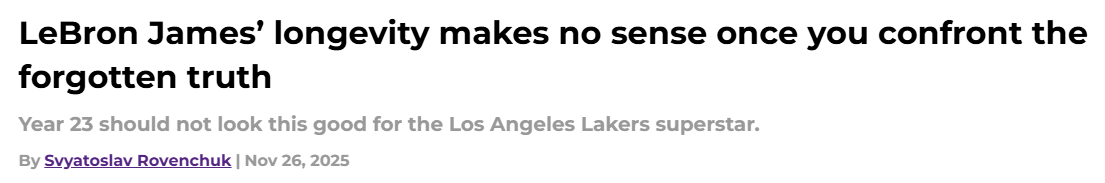

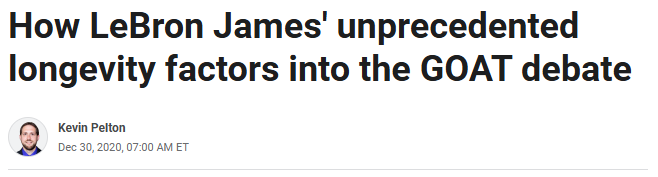

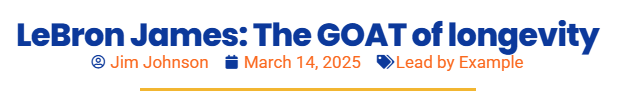

## Segon Model: Classificació per saber si es tracta d'un partit de Lebron o Jordan segons les estadístiques

El segon estudi que he volgut realitzar ha sigut per saber si, únicament amb les estadístiques d'un partit, podem crear un model que pugui predir de quin dels dos jugadors es tracta. Aquest experiment és molt interessant ja que podrem veure realment que, tot i ser considerats els dos millors de la història i tenir un impacte molt semblant, tenien diferències clares en el seu joc i van jugar en dues eras diferents on el tipus d'esport que es jugava s'enfocava de formes molt diferents també.

Primer de tot, hem d'adaptar els datasets per aquest model. En primer lloc, el que he fet ha sigut ajuntar els dos datasets de partits de Jordan i Lebron, assignant-lis els valors 0 i 1 respectivament depenent de a qui pertanyia. Aquesta serà la nostra etiqueta per classificar. A aquest nou dataset li he dit 'careers.csv', i es amb el que treballarem en aquest experiment. A continuació, per que tingui sentit l'estudi, he hagut d'eliminar atributs que feien redundant la predicció. La nostra predicció volem que sigui purament estadística en base al joc, i dades com any del partit, equip pel que jugava, edat, etc. feien que el model no tingués sentit, ja que els dos jugadors van jugar en diferents èpoques, per diferents equips, amb edats diferents (Lebron va entrar a la lliga amb 18 anys, mentre que Jordan amb 21. Jordan es va retirar durant uns anys a meitat de la seva carrera...), i altres variables que feien que la predicció anés a ser directe si manteniem tot això. Finalment, basant-nos en detalls purament del seu estil de joc, ens quedem amb el seguent dataset:

In [31]:
df = pd.read_csv("careers.csv", sep=";")

print("=== Primeres files del dataset de classificació ===")
display(df.head())


=== Primeres files del dataset de classificació ===


,mp,fg,fga,fgp,three,threeatt,threep,ft,fta,ftp,orb,drb,trb,ast,stl,blk,tov,pts,player
0,40:00:00,5,16,0.313,0,0,NaN,6,7,0.857,1,5,6,7,2,4,5,16,0
1,34:00:00,8,13,0.615,0,0,NaN,5,5,1.000,3,2,5,5,2,1,3,21,0
2,34:00:00,13,24,0.542,0,0,NaN,11,13,0.846,2,2,4,5,6,2,3,37,0
3,36:00:00,8,21,0.381,0,0,NaN,9,9,1.000,2,2,4,5,3,1,6,25,0
4,33:00:00,7,15,0.467,0,0,NaN,3,4,0.750,3,2,5,5,1,1,2,17,0


### Tractament de dades i entrenament dels models

Com hem comentat a la introducció, el dataset conté dues columnes amb NaNs que representen percentatges. Aquestes columnes, si el percentatge és 0 sobre 0, queden buides, i les hem de tractar. A continuació tenim els percentatges dels NaNs:

In [32]:
for col in ["threep", "ftp"]:
    nan_pct = df[col].isna().mean() * 100
    print(f"Percentatge de NaNs a {col}: {nan_pct:.2f}%")

Percentatge de NaNs a threep: 16.79%
Percentatge de NaNs a ftp: 1.91%


Les columnes threep i ftp presentaven un percentatge reduït de valors buits (16.79% i 1.91% respectivament). Per tal de mantenir totes les files del dataset i evitar eliminar informació que podria ser útil, s’ha optat per substituir aquests NaNs pel valor mitjà de cada columna. Aquesta estratègia és adequada perquè aquestes variables són percentatges, i la mitjana proporciona una estimació neutral i consistent que no introdueix biaixos extrems ni distorsiona la distribució original de les dades.

Per un tema de format, hem hagut també de pasar la columna de mp (minuts jugats) a minuts decimals, per poder fer millor la classificació.

#### Noves variables

He decidit també crear 3 noves variables resultants de les que ja teniem, que toquen temes que he considerat importants alhora de contextualitzar el joc de cada jugador i la època on jugàven. La primera ha sigut Asistències per Punts, que representa quantes asistències dona el jugador per cada punt que fa. Això ve donat a que Lebron James és conegut com un jugador més versàtil i asistent mentre que Jordan jugava més sol i de forma més egoista. Després tenim Ratio de intents de triple, que representa el percentatge de tirs de 3 punts sobre els seus tirs totals. Això ve donat a que en la època actual on juga Lebron James, el triple és un tir més important que mai, i el volum de triples en la lliga ha augmentat considerablement en respecte al passat. Finalment, tenim Rebots totals per tirs totals, que representa quants rebots agafa el jugador per cada punt que fa. Això ve donat una altre vegada al fet que Lebron James és conegut com un jugador més complet en aquest sentit, agafant molt més rebots, mentre que Jordan és centrava molt més en el joc individual i en fer punts.

#### Entrenament

Un cop fet tot això, i després d'un escalat, entrenarem models de Regressió Logística (max_iter = 2000) i Random Forest (n_estimators = 200). La mètrica que hem triat ha estat Accuracy degut al balanceig de les dades, que com ja hem comentat, només hi ha un 5% més de dades de Lebron que de Jordan. Farem un cross-validation amb 5 folds (també he provat amb 10 folds, però dona resultats mínimament pitjors). Finalment, representarem les matrius de confusió per poder tenir una representació visual dels resultats de cada model, així com les seves corbes ROC i PR.

--------- RESULTATS VALIDACIÓ CREUADA ---------

Regressió Logística:
  Accuracy CV: 0.8435

Random Forest:
  Accuracy CV: 0.8362



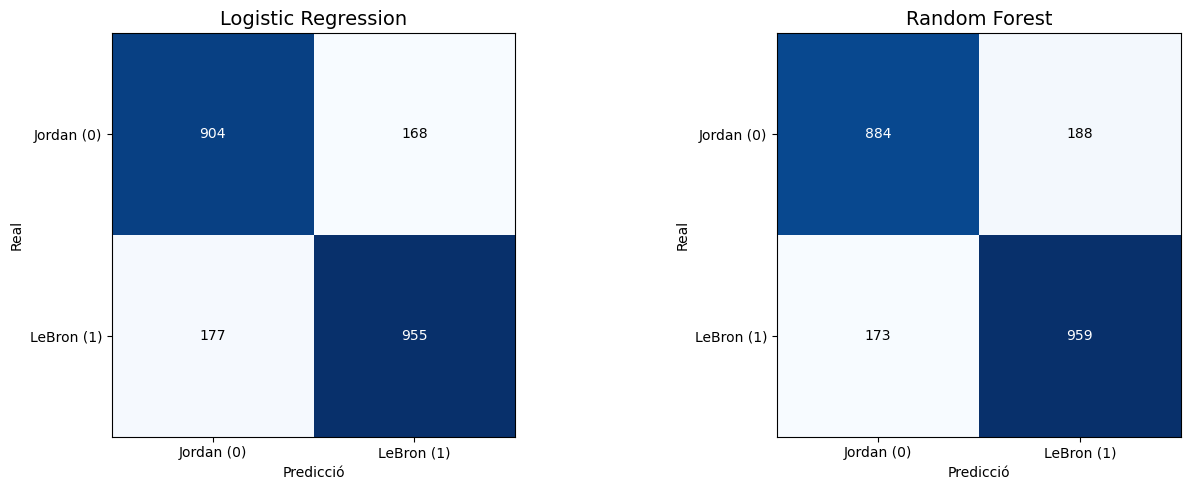

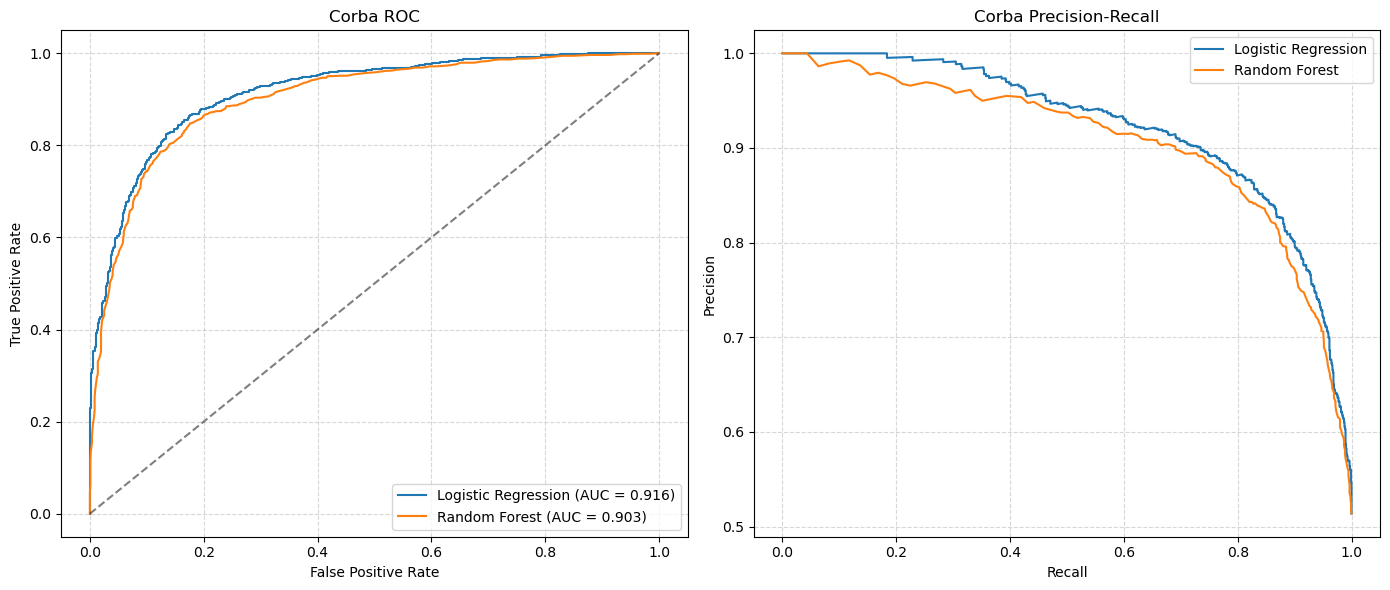

In [33]:
from sklearn.model_selection import cross_validate, cross_val_predict, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc, precision_recall_curve

# 1. CARREGA I TRACTAMENT INICIAL DE DADES

df = pd.read_csv("careers.csv", sep=";")

# Convertir mp ("MM:SS") -> minuts decimals
def mp_to_minutes(mp_str):
    try:
        m, s = mp_str.split(":")
        return int(m) + int(s)/60
    except:
        return np.nan

df["mp"] = df["mp"].apply(mp_to_minutes)

# Convertir totes les columnes numèriques
for col in df.columns:
    if col != "player":
        df[col] = pd.to_numeric(df[col], errors="coerce")

# Omplir NaNs de percentatges (threep, ftp)
for col in ["threep", "ftp"]:
    df[col] = df[col].fillna(df[col].mean())

# 2. FEATURE ENGINEERING

eps = 1e-6

df["AST_per_PTS"] = df["ast"] / (df["pts"] + eps)
df["3PT_Attempt_Ratio"] = df["threeatt"] / (df["fga"] + eps)
df["TRB_per_FGA"] = df["trb"] / (df["fga"] + eps)

df.replace([np.inf, -np.inf], np.nan, inplace=True)

# 3. TRACTAMENT FINAL DE NaNs

for col in df.columns:
    if col != "player":
        df[col] = df[col].fillna(df[col].mean())

# 4. DEFINIR X i Y

X = df.drop(columns=["player"])
Y = df["player"]

# 5. ESCALAT

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 6. DEFINIR MODELS

models = {
    "Regressió Logística": LogisticRegression(random_state=42, max_iter=2000),
    "Random Forest": RandomForestClassifier(random_state=42, n_estimators=200)
}

# Trio ACCURACY com a mètrica, estan balancejats
scoring = ["accuracy"]

kf = KFold(n_splits=5, shuffle=True, random_state=42)

results = {}

# 7. VALIDACIÓ CREUADA (ACCURACY)

print("--------- RESULTATS VALIDACIÓ CREUADA ---------\n")

for name, model in models.items():
    cv_results = cross_validate(model, X_scaled, Y, cv=kf, scoring=scoring)

    results[name] = {
        "Accuracy Mitjana": np.mean(cv_results["test_accuracy"])
    }

    print(f"{name}:")
    print(f"  Accuracy CV: {results[name]['Accuracy Mitjana']:.4f}\n")

# 8. MATRIUS DE CONFUSIÓ AMB CROSS_VAL_PREDICT

def plot_confusion_matrix(cm, title, ax):
    labels = ["Jordan (0)", "LeBron (1)"]
    ax.imshow(cm, cmap=plt.cm.Blues)
    ax.set_title(title, fontsize=14)
    ax.set_xticks(range(2))
    ax.set_yticks(range(2))
    ax.set_xticklabels(labels)
    ax.set_yticklabels(labels)

    thresh = cm.max() / 2
    for i in range(2):
        for j in range(2):
            ax.text(j, i, cm[i, j],
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")

    ax.set_ylabel("Real")
    ax.set_xlabel("Predicció")

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Logistic Regression CM
preds_logreg = cross_val_predict(
    LogisticRegression(random_state=42, max_iter=2000),
    X_scaled, Y, cv=kf
)
cm_logreg = confusion_matrix(Y, preds_logreg)
plot_confusion_matrix(cm_logreg, "Logistic Regression", axes[0])

# Random Forest CM
preds_rf = cross_val_predict(
    RandomForestClassifier(random_state=42, n_estimators=200),
    X_scaled, Y, cv=kf
)
cm_rf = confusion_matrix(Y, preds_rf)
plot_confusion_matrix(cm_rf, "Random Forest", axes[1])

plt.tight_layout()
plt.show()

# 9. CORBES ROC I PRECISION-RECALL

# Probabilitats (per ROC i PR)
probs_logreg = cross_val_predict(
    LogisticRegression(random_state=42, max_iter=2000),
    X_scaled, Y, cv=kf, method="predict_proba"
)[:, 1]

probs_rf = cross_val_predict(
    RandomForestClassifier(random_state=42, n_estimators=200),
    X_scaled, Y, cv=kf, method="predict_proba"
)[:, 1]

# ROC
fpr_logreg, tpr_logreg, _ = roc_curve(Y, probs_logreg)
fpr_rf,     tpr_rf,     _ = roc_curve(Y, probs_rf)

roc_auc_logreg = auc(fpr_logreg, tpr_logreg)
roc_auc_rf     = auc(fpr_rf, tpr_rf)

# PR
prec_logreg, rec_logreg, _ = precision_recall_curve(Y, probs_logreg)
prec_rf,     rec_rf,     _ = precision_recall_curve(Y, probs_rf)

# Figures ROC + PR
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# ROC
axes[0].plot(fpr_logreg, tpr_logreg, label=f"Logistic Regression (AUC = {roc_auc_logreg:.3f})")
axes[0].plot(fpr_rf, tpr_rf, label=f"Random Forest (AUC = {roc_auc_rf:.3f})")
axes[0].plot([0, 1], [0, 1], "k--", alpha=0.5)
axes[0].set_title("Corba ROC")
axes[0].set_xlabel("False Positive Rate")
axes[0].set_ylabel("True Positive Rate")
axes[0].legend()
axes[0].grid(True, linestyle="--", alpha=0.5)

# PR
axes[1].plot(rec_logreg, prec_logreg, label="Logistic Regression")
axes[1].plot(rec_rf, prec_rf, label="Random Forest")
axes[1].set_title("Corba Precision-Recall")
axes[1].set_xlabel("Recall")
axes[1].set_ylabel("Precision")
axes[1].legend()
axes[1].grid(True, linestyle="--", alpha=0.5)

plt.tight_layout()
plt.show()

### Interpretació dels resultats

Els dos models entrenats, Regressió Logística i Random Forest, mostren un rendiment molt similar a l’hora de distingir si un partit pertany a Michael Jordan o a LeBron James a partir de les seves estadístiques de joc. La validació creuada de 5 folds indica que la Regressió Logística obté una accuracy mitjana del 84.35%, mentre que el Random Forest queda lleugerament per sota, amb un 83.62%. Aquest petit avantatge del model lineal ja anticipa que, en aquest cas concret, una frontera de decisió relativament simple és suficient per capturar les diferències en l’estil estadístic dels dos jugadors.

Les matrius de confusió reforcen aquesta lectura: tots dos models encerten la major part de les prediccions, però la Regressió Logística comet lleugerament menys errors en les dues classes. En particular, les prediccions de partits de Jordan i LeBron estan força equilibrades, cosa que confirma que les dades estan ben balancejades i que no hi ha un biaix clar cap a una de les dues classes. Tot i així, veiem una miqueta de bias cap a Jordan a Regressió Logística, i una miqueta cap a Lebron a Random Forest.

Les corbes ROC mostren que tots dos models tenen un comportament robust, obtenint àrees sota la corba de 0.916 per a la Regressió Logística i 0.903 per al Random Forest. Aquest resultat torna a situar el model lineal com a lleugerament superior en separabilitat de classes. Les corbes Precision–Recall mostren el mateix patró: la regressió logística manté una precisió més alta per a qualsevol nivell de recall, indicant un millor compromís entre els dos valors quan es varia el llindar de decisió.

En conjunt, l'anàlisi suggereix que, malgrat ser un model més senzill, la Regressió Logística és el millor model per aquest problema. La seva estabilitat, interpretabilitat i lleuger avantatge en totes les mètriques la converteixen en la millor opció. El Random Forest continua sent una alternativa potent, però en aquest cas no aporta un guany significatiu i pot estar capturant més soroll que patrons reals, ja que el problema sembla adequadament lineal.

A nivell global, els resultats mostren que les estadístiques de joc dels dos jugadors permeten distingir-los de manera fiable, i que el procés de validació creuada ha proporcionat una estimació robusta del rendiment dels models evitant sobreajustos.

### Característiques més importants

Per entendre el context del model i com s'ha pogut arribar a aquests resultats, he volgut mirar quines han sigut les característiques claus alhora de fer la classificació. A continuació tenim els resultats:

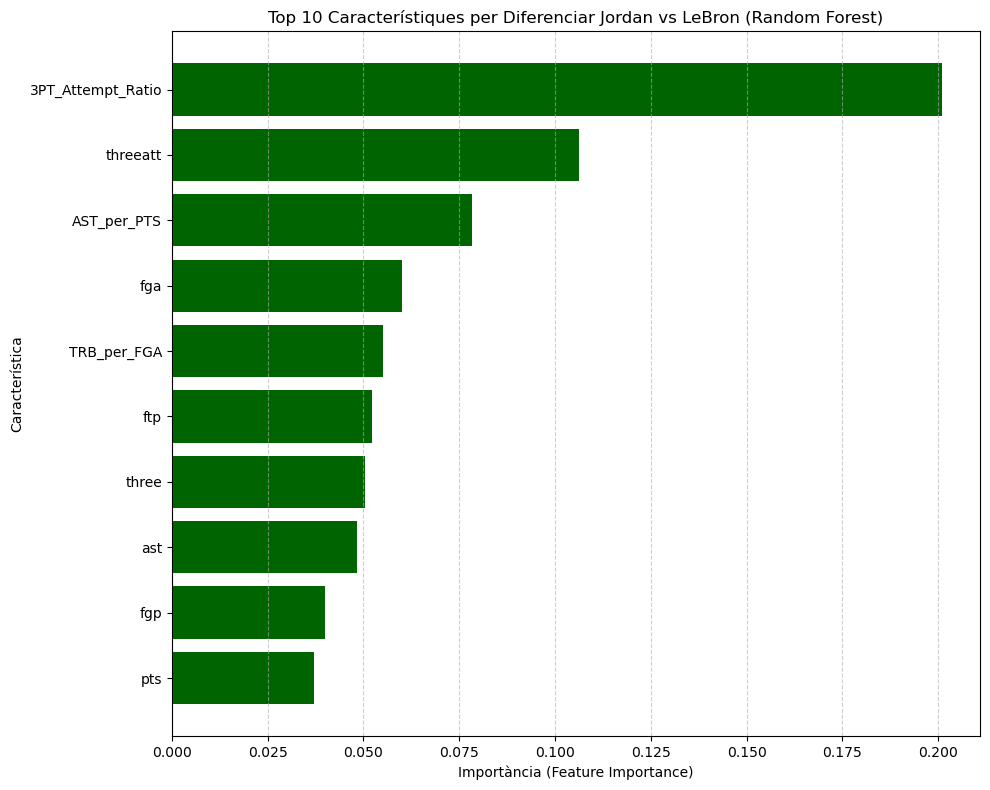


--- Top 10 Característiques més Importants ---
Característica                 |  Importància
---------------------------------------------
3PT_Attempt_Ratio              |       0.2009
threeatt                       |       0.1064
AST_per_PTS                    |       0.0784
fga                            |       0.0600
TRB_per_FGA                    |       0.0550
ftp                            |       0.0522
three                          |       0.0503
ast                            |       0.0482
fgp                            |       0.0401
pts                            |       0.0372


In [34]:
# 1. CARREGA I TRACTAMENT INICIAL DELS NaNs

df = pd.read_csv("careers.csv", sep=";")

# Convertir mp ("MM:SS") -> minuts decimals
def mp_to_minutes(mp_str):
    try:
        m, s = mp_str.split(":")
        return int(m) + int(s)/60
    except:
        return np.nan

df["mp"] = df["mp"].apply(mp_to_minutes)

# Convertir totes les columnes (menys player) a numèriques
for col in df.columns:
    if col != "player":
        df[col] = pd.to_numeric(df[col], errors="coerce")

# Omplir NaNs específics de percentatges
for col in ["threep", "ftp"]:
    df[col] = df[col].fillna(df[col].mean())

# 2. FEATURE ENGINEERING (igual que al model de classificació)

eps = 1e-6

df["AST_per_PTS"] = df["ast"] / (df["pts"] + eps)
df["3PT_Attempt_Ratio"] = df["threeatt"] / (df["fga"] + eps)
df["TRB_per_FGA"] = df["trb"] / (df["fga"] + eps)

df.replace([np.inf, -np.inf], np.nan, inplace=True)

# 3. TRACTAMENT FINAL DE NaNs

for col in df.columns:
    if col != "player":
        df[col] = df[col].fillna(df[col].mean())

# 4. DEFINIR X I Y

X = df.drop(columns=["player"])
Y = df["player"]

# 5. ESCALAT DE DADES

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 6. ENTRENAMENT DEL RANDOM FOREST (per importància)

rf_model = RandomForestClassifier(random_state=42, n_estimators=200)
rf_model.fit(X_scaled, Y)

# 7. IMPORTÀNCIA DE LES FEATURES

feature_names = X.columns
importances = rf_model.feature_importances_

feature_importances_df = pd.DataFrame({
    "Feature": feature_names,
    "Importance": importances
}).sort_values(by="Importance", ascending=False)

top_10 = feature_importances_df.head(10)

# 8. GRÀFIC DE LES 10 FEATURES MÉS IMPORTANTS

plt.figure(figsize=(10, 8))
plt.barh(top_10["Feature"], top_10["Importance"], color="darkgreen")
plt.xlabel("Importància (Feature Importance)")
plt.ylabel("Característica")
plt.title("Top 10 Característiques per Diferenciar Jordan vs LeBron (Random Forest)")
plt.gca().invert_yaxis()
plt.grid(axis="x", linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()

# 9. TAULA AMB LES 10 MILLORS FEATURES

print("\n--- Top 10 Característiques més Importants ---")
print(f"{'Característica':<30} | {'Importància':>12}")
print("-" * 45)

for _, row in top_10.iterrows():
    print(f"{row['Feature']:<30} | {row['Importance']:>12.4f}")


Podem veure, per les dues primeres estadístiques en aquest top 10, que clarament el factor més diferencial entre el joc de Jordan i Lebron es el triple, ja sigui el ratio de triples per tir intentat o purament la quantitat de triples intentats. Això representa clarament no només la diferència en l'estil de joc, sino de la època en la que van jugar. Veiem també que les 3 variables que vaig crear a partir d'altres han sigut molt importants, estan les 3 en el top 5 de més importància. Això reflecteix que les preconcepcions que tenen els aficionats sobre el tipus de jugador que és cadascú són certes i estan fonamentades en una base estadística.

### Creació d'un conjunt de test i resultats finals

Per poder fer la valoració final, he hagut de crear un nou dataset que servirà com a TEST pel meu model. Com que el dataset que teniem, i tot l'entrenament, es basa en partits de temporada regular, he decidit les estadístiques de partits de playoffs que han jugat ambdós jugadors en la seva carrera. Finalment, he pogut trobar totes les estadístiques que necessitava (https://www.basketball-reference.com/players/j/jordami01/gamelog-playoffs/, https://www.basketball-reference.com/players/j/jamesle01/gamelog-playoffs/), i he pogut crear un dataset test amb els últims 175 partits de cada un d'ells a playoffs, adaptant-ho al mateix format estadístic que train. A continuació, fem el test final:

===== ACCURACY SOBRE PLAYOFFS (TEST) =====
Logistic Regression: 0.8229
Random Forest:       0.8314


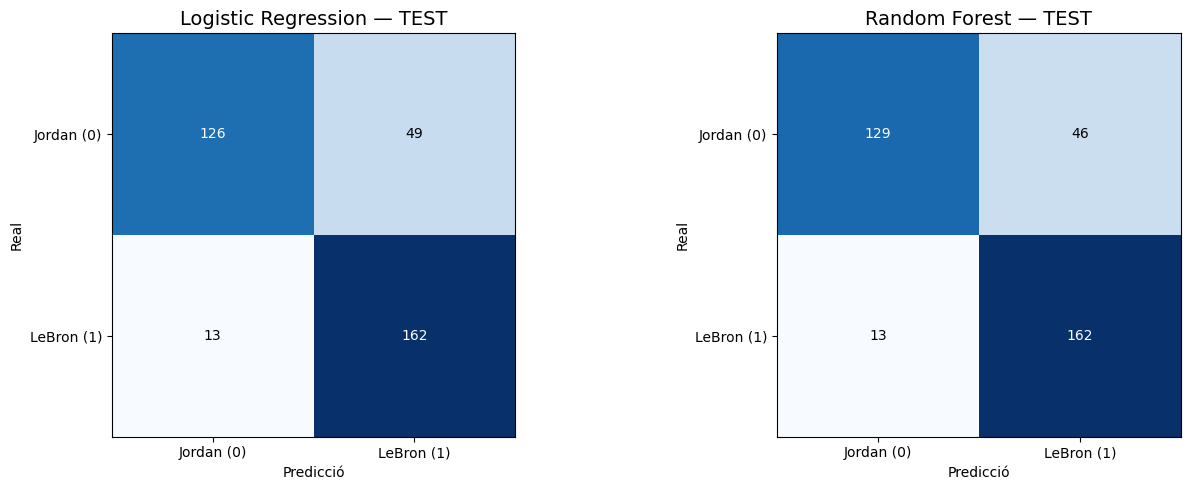

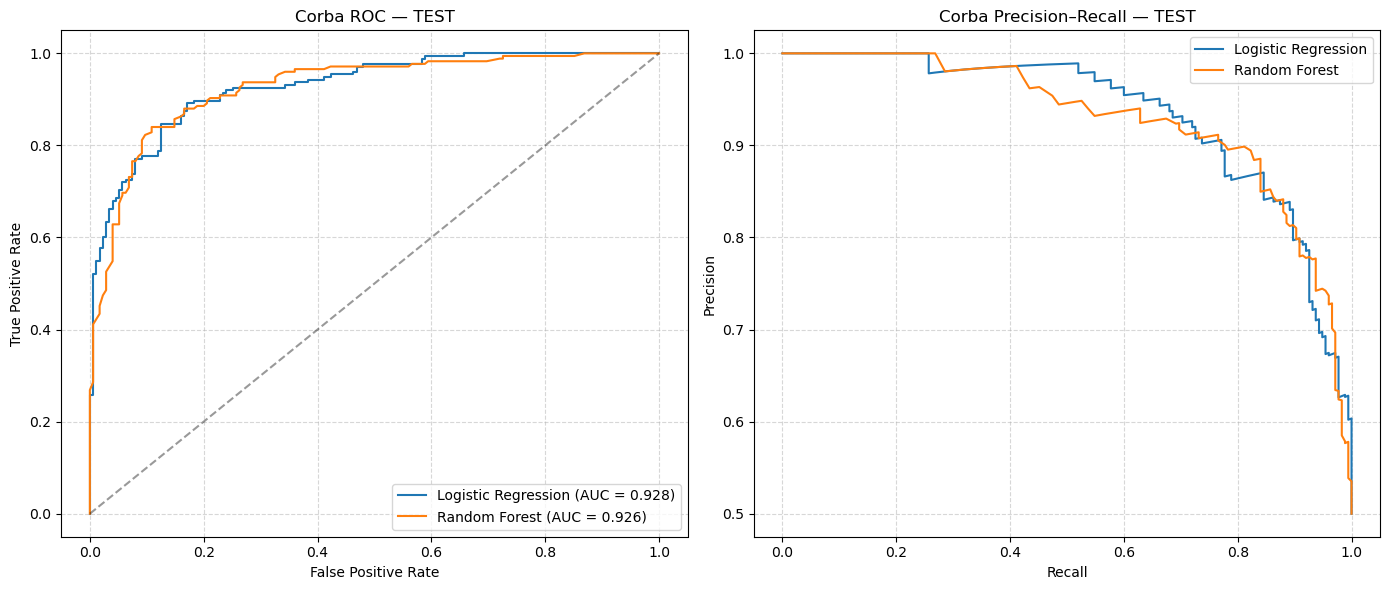


===== COMPARACIÓ TRAIN (CV) vs TEST =====
Logistic Regression:  Train: 0.8435  | Test: 0.8229
Random Forest:        Train: 0.8362  | Test: 0.8314


In [35]:
# ======================================================
# TEST AMB PLAYOFFS: VALIDACIÓ FINAL
# ======================================================

# 1. Carregar dataset de TEST (playoffs)
test = pd.read_csv("careers_playoffs.csv", sep=";")

# 2. Preprocessat EXACTE igual que en TRAIN
test["mp"] = test["mp"].apply(mp_to_minutes)

for col in test.columns:
    if col != "player":
        test[col] = pd.to_numeric(test[col], errors="coerce")

# Omplir NaNs de threep/ftp amb la mitjana del TRAIN
for col in ["threep", "ftp"]:
    test[col] = test[col].fillna(df[col].mean())

# Feature engineering
test["AST_per_PTS"] = test["ast"] / (test["pts"] + eps)
test["3PT_Attempt_Ratio"] = test["threeatt"] / (test["fga"] + eps)
test["TRB_per_FGA"] = test["trb"] / (test["fga"] + eps)

# Reemplaçar infinits
test.replace([np.inf, -np.inf], np.nan, inplace=True)

# Omplir últims NaNs amb les mitjanes del TRAIN
for col in test.columns:
    if col != "player":
        test[col] = test[col].fillna(df[col].mean())

# 3. Definir X_test i y_test
X_test = test.drop(columns=["player"])
y_test = test["player"]

# 4. Escalar test amb el MATEIX scaler
X_test_scaled = scaler.transform(X_test)

# 5. Entrenar models sobre tot el train
logreg_final = LogisticRegression(random_state=42, max_iter=2000)
rf_final = RandomForestClassifier(random_state=42, n_estimators=200)

logreg_final.fit(X_scaled, Y)
rf_final.fit(X_scaled, Y)

# 6. Prediccions i probabilitats sobre TEST
pred_logreg_test = logreg_final.predict(X_test_scaled)
pred_rf_test = rf_final.predict(X_test_scaled)

proba_logreg_test = logreg_final.predict_proba(X_test_scaled)[:, 1]
proba_rf_test     = rf_final.predict_proba(X_test_scaled)[:, 1]

# 7. Accuracy
acc_logreg_test = accuracy_score(y_test, pred_logreg_test)
acc_rf_test = accuracy_score(y_test, pred_rf_test)

print("===== ACCURACY SOBRE PLAYOFFS (TEST) =====")
print(f"Logistic Regression: {acc_logreg_test:.4f}")
print(f"Random Forest:       {acc_rf_test:.4f}")


# MATRIUS DE CONFUSIÓ

def plot_confusion_matrix(cm, title, ax):
    labels = ["Jordan (0)", "LeBron (1)"]
    ax.imshow(cm, cmap=plt.cm.Blues)
    ax.set_title(title, fontsize=14)
    ax.set_xticks(range(2))
    ax.set_yticks(range(2))
    ax.set_xticklabels(labels)
    ax.set_yticklabels(labels)

    thresh = cm.max() / 2
    for i in range(2):
        for j in range(2):
            ax.text(j, i, cm[i, j],
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")

    ax.set_ylabel("Real")
    ax.set_xlabel("Predicció")

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

cm_lr = confusion_matrix(y_test, pred_logreg_test)
plot_confusion_matrix(cm_lr, "Logistic Regression — TEST", axes[0])

cm_rf = confusion_matrix(y_test, pred_rf_test)
plot_confusion_matrix(cm_rf, "Random Forest — TEST", axes[1])

plt.tight_layout()
plt.show()


# 9. ROC + PR SOBRE TEST

# Corba ROC
fpr_lr, tpr_lr, _ = roc_curve(y_test, proba_logreg_test)
fpr_rf, tpr_rf, _ = roc_curve(y_test, proba_rf_test)

auc_lr = auc(fpr_lr, tpr_lr)
auc_rf = auc(fpr_rf, tpr_rf)

plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(fpr_lr, tpr_lr, label=f"Logistic Regression (AUC = {auc_lr:.3f})")
plt.plot(fpr_rf, tpr_rf, label=f"Random Forest (AUC = {auc_rf:.3f})")
plt.plot([0, 1], [0, 1], "k--", alpha=0.4)
plt.title("Corba ROC — TEST")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.5)

# Corba PR
prec_lr, rec_lr, _ = precision_recall_curve(y_test, proba_logreg_test)
prec_rf, rec_rf, _ = precision_recall_curve(y_test, proba_rf_test)

plt.subplot(1, 2, 2)
plt.plot(rec_lr, prec_lr, label="Logistic Regression")
plt.plot(rec_rf, prec_rf, label="Random Forest")
plt.title("Corba Precision–Recall — TEST")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.5)

plt.tight_layout()
plt.show()


# COMPARACIÓ FINAL TRAIN vs TEST

print("\n===== COMPARACIÓ TRAIN (CV) vs TEST =====")
print(f"Logistic Regression:  Train: 0.8435  | Test: {acc_logreg_test:.4f}")
print(f"Random Forest:        Train: 0.8362  | Test: {acc_rf_test:.4f}")

### Interpretació dels resultats

Els resultats obtinguts en el procés de validació final amb el dataset de playoffs mostren un comportament molt coherent entre els dos models entrenats. Durant la fase de cross-validation amb dades de temporada regular, la Regressió Logística presentava una lleugera avantatge en termes d’accuracy (0.8435) respecte a Random Forest (0.8362). Aquesta diferència, tot i ser petita, suggeria que els patrons lineals entre estadístiques eren suficients per separar força bé els estils de joc de Jordan i LeBron.

Tanmateix, en aplicar els models a dades totalment noves (partits de playoffs), que el model no havia vist mai i on sovint els jugadors podrien adoptar rols algo diferents, s’observa una inversió interessant: Random Forest assoleix un accuracy lleugerament superior (0.8314) respecte la Regressió Logística (0.8229). A més, el rendiment del Random Forest pràcticament coincideix amb el seu rendiment en train, cosa que indica una capacitat de generalització molt estable. És a dir, aquest model sembla una mica més robust davant situacions o distribucions lleugerament diferents del conjunt d’entrenament.

Les matrius de confusió aporten una lectura encara més detallada. Tant la Regressió Logística com Random Forest tenen exactament el mateix comportament en la identificació de partits de LeBron: 162 encerts i només 13 errors en tots dos casos. Això demostra que els models capten molt bé les característiques distintives del seu estil estadístic.

En canvi, la diferència entre models apareix en la classificació dels partits de Michael Jordan. La Regressió Logística confon 49 partits de Jordan com si fossin de LeBron, mentre que Random Forest redueix aquest error lleugerament fins als 46. Tot i que la diferència no és gran, sí que reflecteix que el model basat en arbres és capaç de capturar algunes no-linealitats i interaccions entre estadístiques que la regressió lineal pot passar per alt. Jordan presenta més variabilitat estadística al llarg de la seva carrera i, especialment en playoffs, pot adoptar rols més agressius o més distribuïts segons el context. Aquesta variabilitat fa que la frontera de separació lineal sigui una mica menys precisa per ell, i per això Random Forest, que pot modelar patrons més complexos, aconsegueix un petit avantatge.

En conjunt, els resultats mostren que els dos models són fiables i coherents, amb rendiments molt similars tant en train com en test. La Regressió Logística destaca per la seva estabilitat i simplicitat, mentre que Random Forest mostra una lleu millor capacitat de generalització en un entorn més exigent i diferent com són els playoffs. Aquest comportament reforça la idea que ambdós models han capturat correctament els trets principals que distingeixen els dos jugadors, però que el model en arbres rep un petit benefici addicional quan les dades són més irregulars o contenen relacions més complexes entre variables.

### Extra: Observació de falsos positius i negatius

Finalment, com a última part d'aquest cas Kaggle, mirarem algun exemple de falsos positius i falsos negatius, per entendre bé el perquè poden haver fallat, i tenir context sobre fins a on pot arribar aquest tipus de predicció en el bàsquet i perquè mai podrà ser perfecte.

In [38]:
pd.set_option('display.max_columns', None) # Perquè es vegin totes les columnes

# Afegim prediccions al dataframe de test
test["pred_logreg"] = pred_logreg_test
test["pred_rf"] = pred_rf_test

# Logistic Regression
fp_logreg = test[(test["player"] == 0) & (test["pred_logreg"] == 1)]
fn_logreg = test[(test["player"] == 1) & (test["pred_logreg"] == 0)]

# Random Forest
fp_rf = test[(test["player"] == 0) & (test["pred_rf"] == 1)]
fn_rf = test[(test["player"] == 1) & (test["pred_rf"] == 0)]

print("===== LOGISTIC REGRESSION — FALSE POSITIVES (Jordan → LeBron) =====")
display(fp_logreg.head(3))

print("\n===== LOGISTIC REGRESSION — FALSE NEGATIVES (LeBron → Jordan) =====")
display(fn_logreg.head(3))

print("\n===== RANDOM FOREST — FALSE POSITIVES (Jordan → LeBron) =====")
display(fp_rf.head(3))

print("\n===== RANDOM FOREST — FALSE NEGATIVES (LeBron → Jordan) =====")
display(fn_rf.head(3))

===== LOGISTIC REGRESSION — FALSE POSITIVES (Jordan → LeBron) =====


,mp,fg,fga,fgp,three,threeatt,threep,ft,fta,ftp,orb,drb,trb,ast,stl,blk,tov,pts,player,AST_per_PTS,3PT_Attempt_Ratio,TRB_per_FGA,pred_logreg,pred_rf
15,18.975595,10,22,0.455,1,2,0.5,4,7,0.571,2,6,8,8,2,0,3,25,0,0.320000,0.090909,0.363636,1,1
21,18.975595,11,17,0.647,1,2,0.5,11,11,1.000,2,8,10,12,2,0,6,34,0,0.352941,0.117647,0.588235,1,1
22,18.975595,7,17,0.412,0,2,0.0,1,4,0.250,2,6,8,3,1,0,1,15,0,0.200000,0.117647,0.470588,1,1



===== LOGISTIC REGRESSION — FALSE NEGATIVES (LeBron → Jordan) =====


,mp,fg,fga,fgp,three,threeatt,threep,ft,fta,ftp,orb,drb,trb,ast,stl,blk,tov,pts,player,AST_per_PTS,3PT_Attempt_Ratio,TRB_per_FGA,pred_logreg,pred_rf
184,18.975595,8,17,0.471,0,1,0.0,6,6,1.000,0,4,4,3,0,0,0,22,1,0.136364,0.058824,0.235294,0,0
188,18.975595,8,17,0.471,1,2,0.5,15,16,0.938,2,6,8,4,2,1,2,32,1,0.125000,0.117647,0.470588,0,0
192,18.975595,15,25,0.600,1,2,0.5,2,4,0.500,3,8,11,4,2,2,1,33,1,0.121212,0.080000,0.440000,0,0



===== RANDOM FOREST — FALSE POSITIVES (Jordan → LeBron) =====


,mp,fg,fga,fgp,three,threeatt,threep,ft,fta,ftp,orb,drb,trb,ast,stl,blk,tov,pts,player,AST_per_PTS,3PT_Attempt_Ratio,TRB_per_FGA,pred_logreg,pred_rf
15,18.975595,10,22,0.455,1,2,0.5,4,7,0.571,2,6,8,8,2,0,3,25,0,0.320000,0.090909,0.363636,1,1
21,18.975595,11,17,0.647,1,2,0.5,11,11,1.000,2,8,10,12,2,0,6,34,0,0.352941,0.117647,0.588235,1,1
22,18.975595,7,17,0.412,0,2,0.0,1,4,0.250,2,6,8,3,1,0,1,15,0,0.200000,0.117647,0.470588,1,1



===== RANDOM FOREST — FALSE NEGATIVES (LeBron → Jordan) =====


,mp,fg,fga,fgp,three,threeatt,threep,ft,fta,ftp,orb,drb,trb,ast,stl,blk,tov,pts,player,AST_per_PTS,3PT_Attempt_Ratio,TRB_per_FGA,pred_logreg,pred_rf
184,18.975595,8,17,0.471,0,1,0.0,6,6,1.000,0,4,4,3,0,0,0,22,1,0.136364,0.058824,0.235294,0,0
188,18.975595,8,17,0.471,1,2,0.5,15,16,0.938,2,6,8,4,2,1,2,32,1,0.125000,0.117647,0.470588,0,0
192,18.975595,15,25,0.600,1,2,0.5,2,4,0.500,3,8,11,4,2,2,1,33,1,0.121212,0.080000,0.440000,0,0


L’anàlisi detallada dels casos on els models han fallat (falsos positius i falsos negatius) revela alguns patrons interessants que ajuden a entendre per què la classificació no sempre és correcta. Un dels factors més destacats és la variable AST_per_PTS, que sol caracteritzar molt bé el perfil de joc de LeBron James: és habitual que anoti força, però especialment que reparteixi moltes assistències en relació amb els seus punts. Això fa que, en general, aquest atribut sigui un indicador fortament associat a LeBron. Tanmateix, als casos de false positives (Jordan classificat com LeBron) veiem situacions on Jordan presenta valors sorprenentment elevats d’assistències per punt, molt semblants als que podria tenir LeBron en un partit concret. A la vegada, en alguns false negatives (LeBron classificat com Jordan), trobem partits on LeBron té un AST_per_PTS molt baix, cosa que fa que el model interpreti incorrectament que podria ser Jordan.

Aquestes incoherències puntuals tenen una explicació natural: cap jugador manté sempre el mateix estil de joc. De vegades, Jordan podia tenir un partit amb moltes assistències, o LeBron podia tenir una nit d’escàs repartiment i molta anotació, i això els fa “semblar” estadísticament l’un a l’altre en aquests casos concrets. El model, que només veu números i no el context del partit, intenta separar-los basant-se en patrons generals, però quan aquests patrons s’inverteixen o es difuminen en un partit específic, la classificació es torna molt més difícil.

#### Conclusió final

Aquesta observació ens porta directament a una conclusió més global sobre tot el projecte: el bàsquet és un esport altament variable i no determinista, i això fa pràcticament impossible obtenir un model de classificació perfecte. Un jugador que habitualment fa 6–8 assistències pot fer-ne només 1 en un mal partit, o bé 12 en un de molt bo. Un jugador que mitjanament fa 30 punts pot quedar-se en 10 en una nit dolenta o explotar amb 55. Tot això genera un soroll natural en les dades que limita l’eficiència de qualsevol model predictiu.

Tot i aquestes limitacions inherents a l’esport, els nostres models obtenen aproximadament un 83% d’encert tant en validació creuada com en el test real de playoffs, unes xifres molt consistents i més que respectables en aquest tipus de problema. En definitiva, el model no pot capturar totes les variacions humanes i esportives que afecten el joc, però aconsegueix distingir amb força precisió quin jugador pertany cada partit basant-se només en les estadístiques numèriques. En el context de l’NBA, aquesta és probablement la millor aproximació possible.